# Training With DimeNet

This notebook gives an example of how to build and train DimeNet. DimeNet uses both atom distances and angles to generate a more powerful molecular representation than SchNet, though at higher computational cost.

First we import dependencies for the tutorial:

In [1]:
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../..")

from pathlib import Path

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate

To instantiate the model, we need to specify:

- `n_rbf`: number of radial basis functions
- `cutoff`: neighbor list cutoff
- `envelope_p`: exponent in the envelope function
- `n_spher`: maximum `n` value for the spherical basis functions
- `l_spher`: maximum `l` value for the spherical basis functions
- `embed_dim`: embedding dimension for the atomic numbers
- `n_bilinear`: dimension of the vector into which we transform the angles in the spherical basis
- `activation`: name of non-linear activation function
- `n_convolutions`: number of convolutions (or interaction blocks)
- `output_keys`: names of the values we want our model to predict
- `grad_keys`: names of the gradients we want out model to take

Note that instantiating the model takes around 10 seconds. This is mainly because the spherical Bessel functions and spherical harmonics need to be translated from `scipy` into `lambda` expressions with analytical gradients in PyTorch.

In [2]:
modelparams = {"n_rbf": 6,
               "cutoff": 5.0,
               "envelope_p": 5,
               "n_spher": 6,
               "l_spher": 7,
               "embed_dim": 128,
               "n_bilinear": 8,
               "activation": "swish",
               "n_convolutions": 6,
               "output_keys": ["energy"],
               "grad_keys": ["energy_grad"]}

model = get_model(modelparams, model_type="DimeNet")


Next we make a directory for our work and load the ethanol dataset:

In [3]:
DEVICE = 0
OUTDIR = './sandbox_dimenet'
BATCH_SIZE = 40

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)
        
    shutil.move(OUTDIR, newpath)
    
dataset = Dataset.from_file('./data/dataset.pth.tar')

Because DimeNet uses angles as well as distances, we need to generate an angle list in addition to a neighbor list:

In [4]:
angles = dataset.generate_angle_list()
angles[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1465.99it/s]


tensor([[0, 1, 2],
        [0, 1, 3],
        [0, 1, 4],
        ...,
        [8, 7, 4],
        [8, 7, 5],
        [8, 7, 6]])

Next we make the training splits, loaders, and trainer:

In [5]:
train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

loss_fn = loss.build_mse_loss(loss_coef={'energy': 0.1, 'energy_grad': 1})
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy'),
    metrics.MeanAbsoluteError('energy_grad')
]


train_hooks = [
    hooks.MaxEpochHook(100),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S'
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks
)

Now we train and see the results!

In [6]:
T.train(device=DEVICE, n_epochs=100)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | GPU Memory (MB)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.51it/s]


57:47 |     1 |     3.000e-04 |   558.3373 |        272.6825 |     3.3411 |         11.5652 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  4.03it/s]


57:51 |     2 |     3.000e-04 |   154.7388 |         86.2861 |     4.8126 |          6.7891 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  4.08it/s]


57:55 |     3 |     3.000e-04 |    54.1499 |         38.4285 |     1.2266 |          4.4675 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  4.02it/s]


57:59 |     4 |     3.000e-04 |    30.0373 |         25.8362 |     1.0050 |          3.6128 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.91it/s]


58:03 |     5 |     3.000e-04 |    19.9206 |         18.1853 |     1.1811 |          2.9672 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.93it/s]


58:07 |     6 |     3.000e-04 |    14.6581 |         13.0510 |     1.9385 |          2.4741 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.93it/s]


58:12 |     7 |     3.000e-04 |    11.3906 |         10.4153 |     0.7946 |          2.3028 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.77it/s]


58:16 |     8 |     3.000e-04 |     9.5291 |          8.6458 |     1.5664 |          2.0365 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.48it/s]


58:21 |     9 |     3.000e-04 |     9.1707 |          8.5911 |     3.6574 |          1.8588 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.46it/s]


58:25 |    10 |     3.000e-04 |     8.4766 |          9.1099 |     4.4378 |          1.8441 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.70it/s]


58:30 |    11 |     3.000e-04 |     7.8782 |          6.0971 |     2.1195 |          1.6377 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.44it/s]


58:35 |    12 |     3.000e-04 |     6.0772 |          5.4429 |     1.9137 |          1.5575 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.31it/s]


58:40 |    13 |     3.000e-04 |     4.9961 |          4.9498 |     0.8237 |          1.5719 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.48it/s]


58:44 |    14 |     3.000e-04 |     6.0038 |          6.7350 |     3.0684 |          1.7669 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.67it/s]


58:49 |    15 |     3.000e-04 |     5.0409 |          4.4199 |     0.4095 |          1.5195 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.50it/s]


58:54 |    16 |     3.000e-04 |     5.5701 |          6.0553 |     4.5893 |          1.3871 |            2815


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.53it/s]


58:58 |    17 |     3.000e-04 |     4.9661 |          4.7819 |     1.1330 |          1.5026 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.64it/s]


59:03 |    18 |     3.000e-04 |     4.1399 |          4.4915 |     3.4118 |          1.2689 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.56it/s]


59:07 |    19 |     3.000e-04 |     4.3787 |          3.5647 |     1.9956 |          1.2507 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.39it/s]


59:12 |    20 |     3.000e-04 |     2.9672 |          3.3785 |     0.3256 |          1.3432 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.30it/s]


59:17 |    21 |     3.000e-04 |     6.6308 |          9.5639 |     6.8492 |          1.6093 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.64it/s]


59:21 |    22 |     3.000e-04 |     4.3452 |          3.9384 |     1.0708 |          1.4724 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.73it/s]


59:26 |    23 |     3.000e-04 |     3.3497 |          3.7061 |     1.1395 |          1.4111 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.47it/s]


59:31 |    24 |     3.000e-04 |     2.8703 |          3.2116 |     0.5376 |          1.3362 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.60it/s]


59:35 |    25 |     3.000e-04 |     2.7745 |          3.0911 |     0.9400 |          1.2940 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.22it/s]


59:40 |    26 |     3.000e-04 |     2.4366 |          2.8862 |     1.6622 |          1.1781 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.39it/s]


59:45 |    27 |     3.000e-04 |     4.3487 |          3.7707 |     3.1615 |          1.2029 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.29it/s]


59:50 |    28 |     3.000e-04 |     2.5176 |          2.6672 |     0.7139 |          1.1993 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  2.99it/s]


59:56 |    29 |     3.000e-04 |     2.1536 |          2.4229 |     1.7760 |          1.0368 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.16it/s]


00:01 |    30 |     3.000e-04 |     2.1891 |          2.4973 |     2.1879 |          1.0040 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.33it/s]


00:06 |    31 |     3.000e-04 |     4.9106 |          2.6415 |     1.8854 |          1.0905 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.32it/s]


00:11 |    32 |     3.000e-04 |     2.9598 |          2.3299 |     1.2215 |          1.0744 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.32it/s]


00:16 |    33 |     3.000e-04 |     2.1004 |          2.0710 |     1.4239 |          0.9694 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.23it/s]


00:21 |    34 |     3.000e-04 |     1.8032 |          1.7584 |     0.4497 |          0.9289 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.48it/s]


00:26 |    35 |     3.000e-04 |     1.8516 |          1.8732 |     0.3780 |          0.9759 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.59it/s]


00:30 |    36 |     3.000e-04 |     1.7866 |          2.0567 |     1.0136 |          1.0084 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.64it/s]


00:35 |    37 |     3.000e-04 |     1.9894 |          2.0064 |     0.8227 |          1.0012 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.37it/s]


00:39 |    38 |     3.000e-04 |     2.9780 |          2.0704 |     1.8975 |          0.9130 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.22it/s]


00:44 |    39 |     3.000e-04 |     2.4271 |          2.4883 |     0.2727 |          1.1830 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.25it/s]


00:49 |    40 |     3.000e-04 |     1.5323 |          1.6794 |     1.2094 |          0.8752 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.20it/s]


00:54 |    41 |     3.000e-04 |     1.7851 |          2.5843 |     3.1821 |          0.8982 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.57it/s]


00:59 |    42 |     3.000e-04 |     3.0221 |          1.7905 |     0.6874 |          0.9478 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.47it/s]


01:04 |    43 |     3.000e-04 |     1.5405 |          1.7066 |     0.4680 |          0.9377 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.31it/s]


01:09 |    44 |     3.000e-04 |     1.3518 |          1.8389 |     1.8221 |          0.8721 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.29it/s]


01:14 |    45 |     3.000e-04 |     1.4448 |          2.4010 |     3.1364 |          0.8395 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.67it/s]


01:18 |    46 |     3.000e-04 |     2.5087 |          1.6786 |     1.2487 |          0.8817 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.33it/s]


01:23 |    47 |     3.000e-04 |     1.6027 |          2.3567 |     0.2523 |          1.1577 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.49it/s]


01:28 |    48 |     3.000e-04 |     1.8797 |          2.1531 |     1.2090 |          1.0533 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.66it/s]


01:32 |    49 |     3.000e-04 |     1.9311 |          1.5944 |     1.0686 |          0.8611 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.46it/s]


01:37 |    50 |     3.000e-04 |     2.2260 |          2.7534 |     2.3190 |          1.0902 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.53it/s]


01:41 |    51 |     3.000e-04 |     2.1378 |          1.7448 |     1.9118 |          0.8403 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.60it/s]


01:46 |    52 |     3.000e-04 |     1.5116 |          1.4748 |     0.2884 |          0.8701 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.61it/s]


01:51 |    53 |     3.000e-04 |     1.1235 |          1.4048 |     1.1911 |          0.8048 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.41it/s]


01:55 |    54 |     3.000e-04 |     2.6944 |          3.0398 |     3.6796 |          0.9158 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.11it/s]


02:01 |    55 |     3.000e-04 |     1.4681 |          1.3259 |     0.4357 |          0.8125 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.41it/s]


02:05 |    56 |     3.000e-04 |     1.0782 |          1.1796 |     0.2008 |          0.7680 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.33it/s]


02:10 |    57 |     3.000e-04 |     1.0278 |          1.2518 |     0.8074 |          0.7750 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.55it/s]


02:15 |    58 |     3.000e-04 |     0.9631 |          1.5403 |     1.9760 |          0.7591 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.22it/s]


02:20 |    59 |     3.000e-04 |     2.9838 |          1.5380 |     1.1976 |          0.8367 |            3257


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.61it/s]


02:24 |    60 |     3.000e-04 |     1.6645 |          1.9199 |     1.0175 |          0.9814 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.52it/s]


02:29 |    61 |     3.000e-04 |     1.5327 |          1.6185 |     1.7195 |          0.8365 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.64it/s]


02:33 |    62 |     3.000e-04 |     1.4736 |          1.2938 |     0.3900 |          0.8186 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.54it/s]


02:38 |    63 |     3.000e-04 |     1.0460 |          1.3568 |     0.4662 |          0.8414 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.23it/s]


02:43 |    64 |     3.000e-04 |     1.0758 |          1.1516 |     0.7128 |          0.7422 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.48it/s]


02:48 |    65 |     3.000e-04 |     1.0926 |          1.3657 |     1.2353 |          0.7897 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.77it/s]


02:52 |    66 |     3.000e-04 |     0.9855 |          1.3576 |     1.5123 |          0.7550 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.30it/s]


02:57 |    67 |     3.000e-04 |     1.7777 |          2.1300 |     3.0736 |          0.7856 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.63it/s]


03:01 |    68 |     3.000e-04 |     1.2610 |          1.8989 |     0.8800 |          0.9865 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.38it/s]


03:06 |    69 |     3.000e-04 |     1.1784 |          1.1536 |     0.1828 |          0.7593 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.64it/s]


03:10 |    70 |     3.000e-04 |     1.1001 |          1.2436 |     0.9733 |          0.7661 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.72it/s]


03:15 |    71 |     3.000e-04 |     1.1728 |          1.5801 |     1.1286 |          0.8719 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.91it/s]


03:19 |    72 |     3.000e-04 |     1.9811 |          2.2348 |     3.1471 |          0.8102 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.72it/s]


03:23 |    73 |     3.000e-04 |     1.4206 |          1.7139 |     0.8827 |          0.9301 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  4.02it/s]


03:27 |    74 |     3.000e-04 |     1.1221 |          1.0409 |     0.3114 |          0.7282 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  4.06it/s]


03:31 |    75 |     3.000e-04 |     1.0005 |          1.0440 |     0.7314 |          0.7061 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.98it/s]


03:35 |    76 |     3.000e-04 |     0.8699 |          1.3401 |     1.3822 |          0.7865 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.97it/s]


03:39 |    77 |     3.000e-04 |     0.8884 |          1.0529 |     0.3943 |          0.7358 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.82it/s]


03:44 |    78 |     3.000e-04 |     2.5780 |          1.7771 |     2.2625 |          0.7881 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.92it/s]


03:48 |    79 |     3.000e-04 |     1.3490 |          0.9637 |     0.2984 |          0.6957 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.95it/s]


03:52 |    80 |     3.000e-04 |     0.8111 |          1.0857 |     0.7612 |          0.7284 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.91it/s]


03:56 |    81 |     3.000e-04 |     0.8696 |          1.4119 |     0.2671 |          0.8805 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.88it/s]


04:00 |    82 |     3.000e-04 |     0.9197 |          1.1623 |     0.3761 |          0.7839 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.81it/s]


04:04 |    83 |     3.000e-04 |     0.8888 |          0.8723 |     0.3859 |          0.6569 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.83it/s]


04:09 |    84 |     3.000e-04 |     0.9556 |          1.1204 |     0.2145 |          0.7540 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.50it/s]


04:13 |    85 |     3.000e-04 |     1.0461 |          1.1962 |     0.8742 |          0.7505 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.74it/s]


04:18 |    86 |     3.000e-04 |     1.4620 |          2.1188 |     2.7266 |          0.8951 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.67it/s]


04:22 |    87 |     3.000e-04 |     1.3912 |          1.3196 |     0.1949 |          0.8402 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.22it/s]


04:27 |    88 |     3.000e-04 |     1.2243 |          1.2578 |     1.8400 |          0.6810 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.12it/s]


04:32 |    89 |     3.000e-04 |     0.8965 |          1.0588 |     0.3454 |          0.7500 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.12it/s]


04:37 |    90 |     3.000e-04 |     0.8616 |          1.1971 |     1.1340 |          0.7571 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.34it/s]


04:42 |    91 |     3.000e-04 |     0.8753 |          0.9767 |     0.2957 |          0.7117 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.63it/s]


04:47 |    92 |     3.000e-04 |     0.9188 |          2.1153 |     3.1949 |          0.7534 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.20it/s]


04:52 |    93 |     3.000e-04 |     2.9583 |          3.1846 |     3.5923 |          0.9614 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.49it/s]


04:56 |    94 |     3.000e-04 |     1.9267 |          2.3849 |     1.5126 |          1.0569 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.51it/s]


05:01 |    95 |     3.000e-04 |     1.7247 |          2.5375 |     1.3875 |          1.1106 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.15it/s]


05:06 |    96 |     3.000e-04 |     1.5553 |          1.1751 |     0.4347 |          0.7783 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:04<00:00,  3.30it/s]


05:11 |    97 |     3.000e-04 |     1.5379 |          1.9764 |     0.6001 |          0.9461 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.86it/s]


05:15 |    98 |     3.000e-04 |     1.0810 |          1.4259 |     0.2110 |          0.9022 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.64it/s]


05:20 |    99 |     3.000e-04 |     1.0133 |          1.1268 |     0.4036 |          0.7438 |            3299


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 14/15 [00:03<00:00,  3.75it/s]


05:24 |   100 |     3.000e-04 |     0.8121 |          1.3004 |     0.4682 |          0.8636 |            3299


We pick the model that got the best validation score and evaluate it on the test set:

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


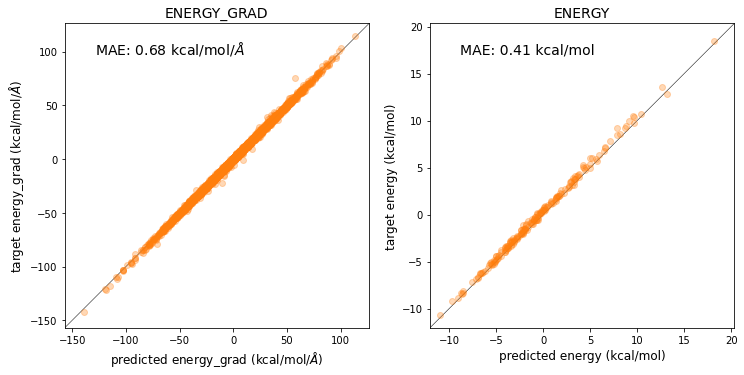

In [7]:
results, targets, val_loss = evaluate(T.get_best_model(), 
                                      test_loader, 
                                      loss_fn, 
                                      device=DEVICE)


units = {
    'energy_grad': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

for ax, key in zip(ax_fig, units.keys()):
    pred = torch.stack(results[key], dim=0).view(-1).detach().cpu().numpy()
    targ = torch.stack(targets[key], dim=0).view(-1).detach().cpu().numpy()
    mae = abs(pred-targ).mean()
    
    ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)
    ax.text(0.1, 0.9, 'MAE: %.2f %s' % (mae, units[key]), 
           transform=ax.transAxes, fontsize=14)

plt.show()

The force and energy errors are respectively 2.5$\times$ and 3.5$\times$ smaller than the SchNet errors trained on the same data (0.62 vs. 1.55 kcal/mol/A and 0.24 vs. 0.86 kcal/mol)!

# For fun: visualizing the basis functions
We can look at the radial and spherical basis functions to see what they look like. We can build the radial functions ourselves and compare them with and without the polynomial envelope: 

In [14]:
from nff.nn.layers import Envelope

envelope_p = 5
envelope = Envelope(envelope_p)

Layers with and without envelope function:

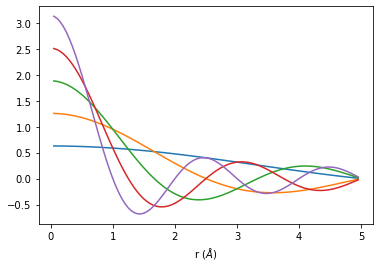

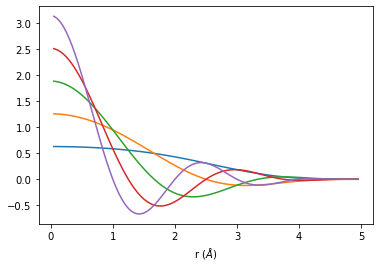

In [15]:
cutoff = 5.0

n_rbf = 5
d = torch.arange(0, cutoff, 0.05).reshape(-1, 1)
n = torch.arange(1, n_rbf + 1).float()
k_n = n * np.pi / cutoff
env = envelope(d / 5)

arg = torch.sin(k_n * d) / d
plt.plot(d, arg)
plt.xlabel("r ($\AA$)")
plt.show()

plt.plot(d, arg *env)
plt.xlabel("r ($\AA$)")

plt.show()

We can also get the layers directly from the module `DimeNetRadialBasis`:

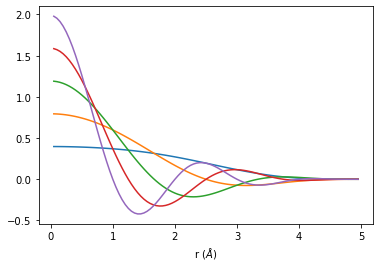

In [16]:
from nff.nn.layers import DimeNetRadialBasis, DimeNetSphericalBasis

dime_rbf = DimeNetRadialBasis(n_rbf=n_rbf,
                 cutoff=cutoff,
                 envelope_p=envelope_p)
out = dime_rbf(d)
plt.plot(d, out.detach().numpy())
plt.xlabel("r ($\AA$)")
plt.show()

Let's take a look at spherical basis functions, which we get from the `DimeNetSphericalBasis` module. First instantiate the module:

In [17]:
n_spher = 4
l_spher = 4
dime_sbf = DimeNetSphericalBasis(l_spher=l_spher,
                 n_spher=n_spher,
                 cutoff=5.0,
                 envelope_p=6)

Then make an x-y grid, calculate the distances and angles at each point on the grid, get the radial and angular parts of the spherical basis functions, and plot their product:

In [18]:
self = dime_sbf

pos_x = torch.arange(0.05, self.cutoff * 1.2, 0.05)
neg_x = torch.arange(-self.cutoff * 1.2, -0.05, 0.05)

x = torch.cat([neg_x, pos_x])
y = torch.cat([neg_x, pos_x])


xv, yv = np.meshgrid(x, y)
xv = torch.Tensor(xv)
yv = torch.Tensor(yv)
                     
angles = torch.atan2(input=xv, other=yv)
d = (xv ** 2 + yv ** 2) ** 0.5

d_scaled = d / self.cutoff
rbf = [f(d_scaled) for f in self.bessel_funcs]
rbf = torch.stack(rbf, dim=1)

u = self.envelope(d_scaled)
cbf = [f(angles) for f in self.sph_funcs]
cbf = torch.stack(cbf, dim=1)


/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


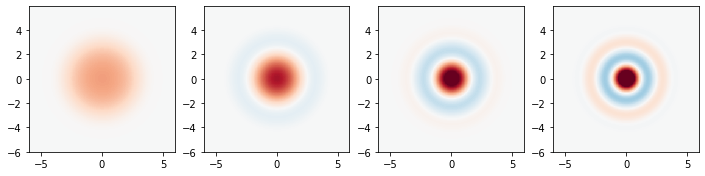

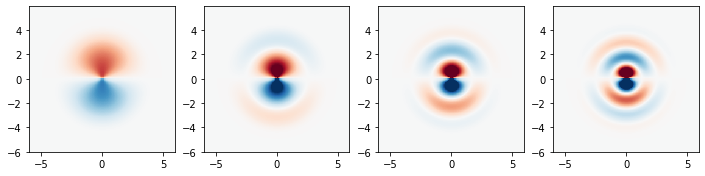

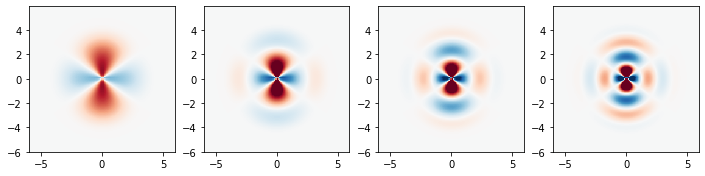

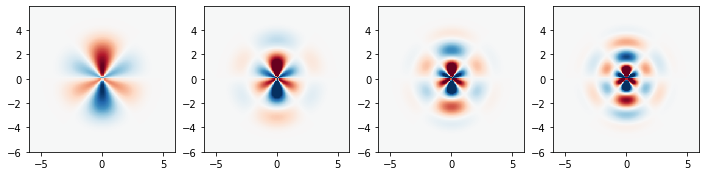

In [19]:
for l in range(l_spher):
    totals = []
    for n in range(n_spher):
        total = cbf[:, l, :] * rbf[:, n, :] * u
        mask = np.heaviside(cutoff - d, 0)
        totals.append(total * mask)
        
    fig, ax_fig = plt.subplots(1, n_spher, figsize=(12, 6))

    
    for i, ax in enumerate(ax_fig):
        z = -totals[i].numpy() 
        mesh = ax.pcolormesh(xv, yv, z, cmap='RdBu',
                            vmin=-3,
                            vmax=3)
        ax.set_aspect(1)
        